In [1]:
import pandas as pd

from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

import numpy as np
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OrdinalEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# category selector
cat_selector = make_column_selector(dtype_include=object)
# numeric selector
num_selector = make_column_selector(dtype_include=np.number)

# category encoder
cat_tree_processor = OrdinalEncoder(
    handle_unknown="use_encoded_value", unknown_value=-1)

# imputer
num_tree_processor = SimpleImputer(strategy="mean", add_indicator=True)

# tree based model precessor
tree_preprocessor = make_column_transformer(
    (num_tree_processor, num_selector), (cat_tree_processor, cat_selector))


def make_rf_pipeline(
        n_estimators: int = 800, random_state: int = 42) -> Pipeline:
    """make random forest pipeline

    Args:
        n_estimators (int, optional): number of estimators. Defaults to 800.
        random_state (int, optional):  Defaults to 42.

    Returns:
        Pipeline: Sklearn pipeline
    """
    return make_pipeline(
        tree_preprocessor,
        RandomForestRegressor(
            random_state=random_state, n_estimators=n_estimators))

def plot_feat_importance(importances, index):
    """plot random forest importance

    Args:
        importances (_type_): feat importance 
        index (_type_): feat name
    """
    forest_importances = pd.Series(
        importances, index=index).sort_values(ascending=False)
    fig, ax = plt.subplots()
    forest_importances.plot.bar(ax=ax)
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [21]:
data = pd.read_csv('../data/curated/feature_data.csv')
data = data[data.property_type != 'Carspace']
data['Crime Rate'] = data['Crime Count']/data['Population']

def transform_property_type(x):
    out = x
    if x not in ('House', 'Apartment / Unit / Flat', 'Townhouse', 'Studio', 'Villa'):
        out = 'Others'
    return out

data['property_type'] = data.property_type.apply(transform_property_type)
# data['heating_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Heating' in xx]) > 0 ))
# data['garden_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Garden' in xx]) > 0 ))
# data['parking_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Parking' in xx]) > 0 ))
# data['balcony_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Balcony' in xx]) > 0 ))
# data['laundry_feat'] = data['Property Features'].apply(lambda x: int(len([_ for xx in eval(x) if 'Laundry' in xx]) > 0 ))

data.fillna(-1, inplace=True)

data.drop(columns=['Unnamed: 0', 'Unnamed: 0.1', 'Property Address', 'Health Instituion', 'Bus Station',
                    'Shopping_Center_Name', 'School Name', 'Bus Duration', 'School Duration',
                    'Health Duration', 'Shop Duration', 'Postcode', 'Crime Count', #'Property Features'
                   ], inplace=True)

# ## Drop outliers
data = data[data['Weekly Rental Price'] < 5000]

/var/folders/6h/1_h0dg6s6wj8yz6rsq27r0dr0000gn/T/ipykernel_17378/298355118.py:1: DtypeWarning: Columns (11,14) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('feature_data.csv')
/var/folders/6h/1_h0dg6s6wj8yz6rsq27r0dr0000gn/T/ipykernel_17378/298355118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Crime Rate'] = data['Crime Count']/data['Population']
/var/folders/6h/1_h0dg6s6wj8yz6rsq27r0dr0000gn/T/ipykernel_17378/298355118.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

In [23]:
X = data.drop(columns='Weekly Rental Price')
y = data['Weekly Rental Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.3)

In [24]:
rf_pipeline = make_rf_pipeline(random_state=42, n_estimators=500)
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('simpleimputer',
                                                  SimpleImputer(add_indicator=True),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x12f9ce040>),
                                                 ('ordinalencoder',
                                                  OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                 unknown_value=-1),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x1300c30d0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(n_estimators=500, random_state=42))])

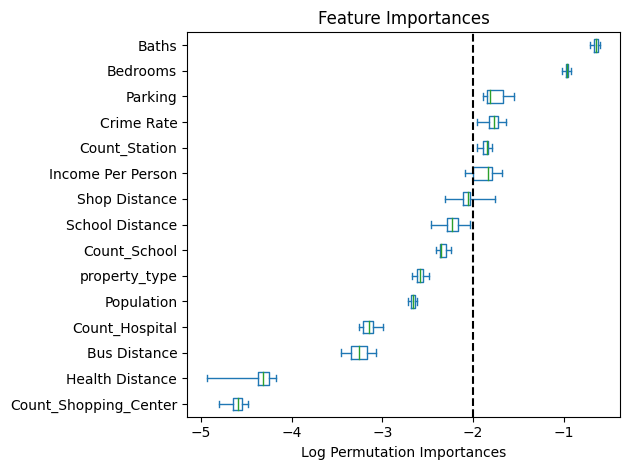

In [25]:
result = permutation_importance(
    rf_pipeline, X_test, y_test, n_repeats=15, random_state=42, n_jobs=4
)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X.columns[sorted_importances_idx],
)
ax = importances.apply(np.log).plot.box(vert=False, whis=10)
ax.set_title("Feature Importances")
ax.axvline(x=-2, color="k", linestyle="--")
ax.set_xlabel("Log Permutation Importances")
ax.figure.tight_layout()
plt.savefig('outputs/feat_importance.png')

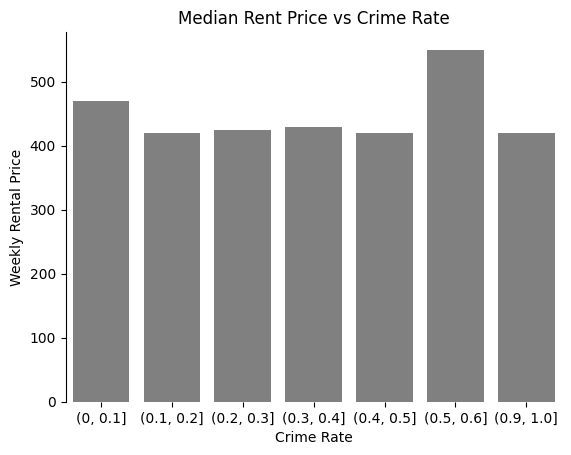

In [110]:
plot_df = data.groupby(by=data['Crime Rate'].apply(lambda x: np.round(x, 1)))['Weekly Rental Price'].median().iloc[1:]
plot_df = plot_df.reset_index()
plot_df['Crime Rate'] = pd.Series(['(0, 0.1]', '(0.1, 0.2]', '(0.2, 0.3]', '(0.3, 0.4]', '(0.4, 0.5]', '(0.5, 0.6]', '(0.9, 1.0]'])
ax = sns.barplot(x='Crime Rate', y='Weekly Rental Price', data=plot_df, color='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title('Median Rent Price vs Crime Rate')
plt.savefig('outputs/crime_rate.png')

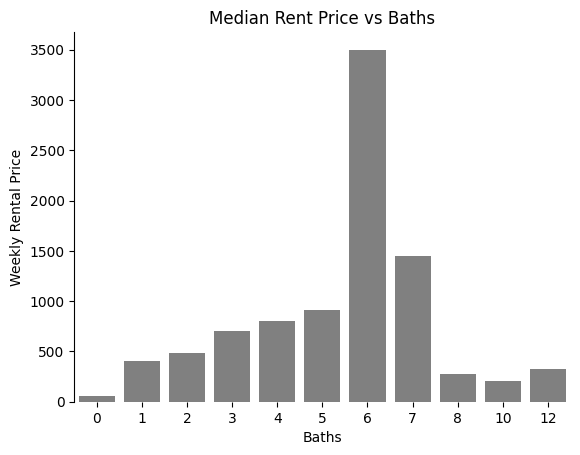

In [111]:
plot_df = data.groupby('Baths')['Weekly Rental Price'].median()
plot_df = plot_df.reset_index()
ax = sns.barplot(x='Baths', y='Weekly Rental Price', data=plot_df, color='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title('Median Rent Price vs Baths')
plt.savefig('outputs/baths.png')


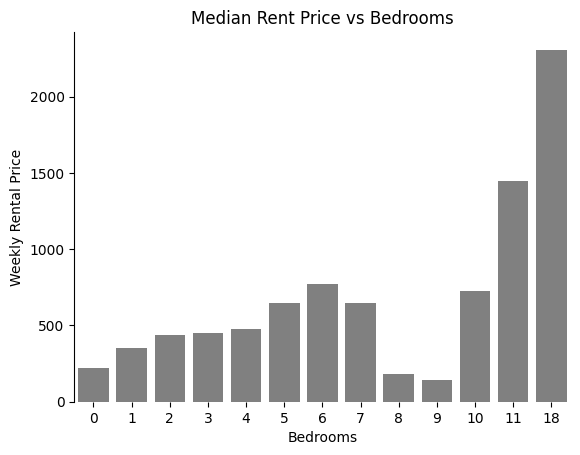

In [112]:
plot_df = data.groupby('Bedrooms')['Weekly Rental Price'].median()
plot_df = plot_df.reset_index()
ax = sns.barplot(x='Bedrooms', y='Weekly Rental Price', data=plot_df, color='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title('Median Rent Price vs Bedrooms')
plt.savefig('outputs/Bedrooms.png')

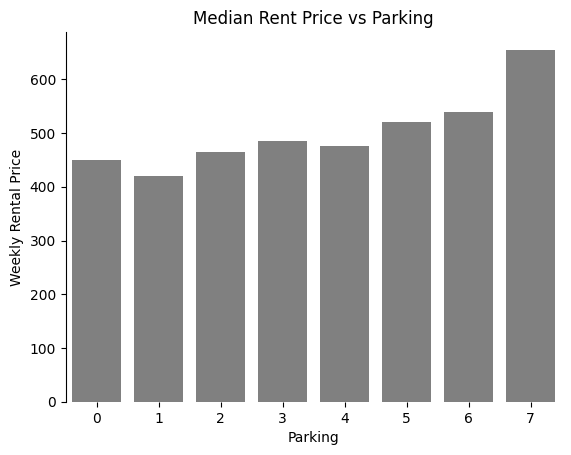

In [117]:
plot_df = data.groupby('Parking')['Weekly Rental Price'].median()
plot_df = plot_df.reset_index()
plot_df = plot_df.iloc[:8]
ax = sns.barplot(x='Parking', y='Weekly Rental Price', data=plot_df, color='gray')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
plt.title('Median Rent Price vs Parking')
plt.savefig('outputs/Parking.png')